# CYBERML – Analyse du CIC IoT-DIAD 2024

Ce notebook conçoit et évalue une chaîne de traitement batch pour **(i)** la détection d’anomalies (non supervisée) et **(ii)** la classification d’attaques (supervisée), à partir de caractéristiques réseau extraites de fichiers CSV.

Point important : l’évaluation utilise un **split par fichier** (colonne `group`) pour éviter que des échantillons issus du même CSV se retrouvent à la fois en train et en test.


## 1. Introduction

Objectif : construire un pipeline reproductible pour des données de flux en cybersécurité, comparer **3 algorithmes non supervisés** et **3 algorithmes supervisés**, et rapporter les métriques requises :
- Matrice de confusion, Précision, Rappel, AUPRC, Balanced accuracy, MCC.

On commence en binaire (**Benign vs Attack**) puis on augmente progressivement la diversité des attaques.


In [1]:
import os
import random
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    average_precision_score,
    matthews_corrcoef,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

BASE_DIR = "./Device_Identification_Anomaly_Detection-Packet_Based_Features"
TARGET_FAMILIES = ["Benign", "BruteForce", "DDoS", "DoS", "Mirai", "Recon", "Spoofing", "Web-Based"]
DROP_CANDIDATES = {"Flow ID","Src IP","Dst IP","Src Port","Dst Port","Timestamp","Unnamed: 0","flow_id","src_ip","dst_ip","src_port","dst_port","timestamp","src_mac","dst_mac","stream"}
DROP_PATTERNS = ["source ip", "destination ip", "src ip", "dst ip", "src_ip", "dst_ip", "src port", "dst port", "src_port", "dst_port", "src mac", "dst mac", "src_mac", "dst_mac", "timestamp", "flow id", "flow_id"]
CANONICAL_FAMILY = {
    "benign": "Benign",
    "benigntraffic": "Benign",
    "ddos": "DDoS",
    "dos": "DoS",
    "mirai": "Mirai",
    "recon": "Recon",
    "spoofing": "Spoofing",
    "webbased": "Web-Based",
    "bruteforce": "BruteForce",
}

MAX_ROWS_PER_FAMILY = 3_000
MAX_ROWS_PER_SUBTYPE = 10_000
MAX_ROWS_BINARY = 50_000

## 2. Jeu de données et protocole expérimental

Jeu de données : **CIC IoT-DIAD 2024 – Device Identification / Anomaly Detection (Packet Based Features)**.

Dans cette version du notebook, on utilise **toutes les attaques** disponibles (dans la limite de budgets RAM-safe) :
- Benign
- BruteForce
- DDoS
- DoS
- Mirai
- Recon
- Spoofing
- Web-Based

Point critique : le split train/test est fait **par fichier (group split)** pour éviter la fuite de données (échantillons très similaires d’un même CSV en train et en test).


## 3. Chargement et préparation des données

Les CSV sont chargés de manière *RAM-safe* (par chunks) et agrégés dans 3 DataFrames :
- `df_binaire` : Benign vs Attack
- `df_familles` : familles d’attaque
- `df_st` : sous-types d’attaque

Mesures anti-fuite / anti-biais :
- Suppression des colonnes identifiantes (`src_ip`, `dst_ip`, ports, MAC, timestamps, etc.).
- Échantillonnage par fichier (cap par fichier puis cap global) pour conserver plusieurs fichiers par classe.
- Split train/test **par fichier** via la colonne `group`.


In [2]:
def should_drop(col: str) -> bool:
    name = col.strip()
    low = name.lower()
    low_space = low.replace("_", " ")
    drop_candidates_low = {c.lower() for c in DROP_CANDIDATES}
    if low in drop_candidates_low:
        return True
    if any((p in low) or (p in low_space) for p in DROP_PATTERNS):
        return True
    return False

def infer_family_subtype(csv_path: str):
    rel = os.path.relpath(csv_path, BASE_DIR)
    parts = rel.split(os.sep)
    key = "".join(ch for ch in parts[0].lower() if ch.isalnum())
    family = CANONICAL_FAMILY.get(key, parts[0])
    subtype = parts[1] if len(parts) >= 3 else family
    return family, subtype

def list_all_flow_csvs():
    paths = []
    for root, _, files in os.walk(BASE_DIR):
        for f in files:
            if f.endswith(".csv"):
                paths.append(os.path.join(root, f))
    return sorted(paths)

def eval(y_true, y_pred, y_score, title, y_proba=None, classes=None):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_score_arr = None if y_score is None else np.asarray(y_score)
    y_proba_arr = None if y_proba is None else np.asarray(y_proba)
    if y_proba_arr is None and y_score_arr is not None and y_score_arr.ndim == 2:
        y_proba_arr = y_score_arr

    is_multiclass = False
    if classes is not None:
        is_multiclass = len(classes) > 2
    else:
        is_multiclass = np.unique(y_true).size > 2

    if is_multiclass:
        labels_present = np.unique(y_true)
        prec = precision_score(y_true, y_pred, average="macro", labels=labels_present, zero_division=0)
        rec = recall_score(y_true, y_pred, average="macro", labels=labels_present, zero_division=0)
        cm_bal = confusion_matrix(y_true, y_pred, labels=labels_present)
        with np.errstate(divide="ignore", invalid="ignore"):
            per_class = np.diag(cm_bal) / cm_bal.sum(axis=1)
        bal_acc = float(np.nanmean(per_class))
        mcc = matthews_corrcoef(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred, labels=labels_present)

        auprc = None
        if classes is not None and y_proba_arr is not None and y_proba_arr.ndim == 2:
            Y = label_binarize(y_true, classes=np.arange(len(classes)))
            present = Y.sum(axis=0) > 0
            if present.any():
                auprc = average_precision_score(Y[:, present], y_proba_arr[:, present], average="macro")
        return {
            "title": title,
            "cm": cm,
            "precision": float(prec),
            "recall": float(rec),
            "auprc": None if auprc is None else float(auprc),
            "balanced_acc": float(bal_acc),
            "mcc": float(mcc),
        }

    # Binaire
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    labels_present = np.unique(y_true)
    cm_bal = confusion_matrix(y_true, y_pred, labels=labels_present)
    with np.errstate(divide="ignore", invalid="ignore"):
        per_class = np.diag(cm_bal) / cm_bal.sum(axis=1)
    bal_acc = float(np.nanmean(per_class))
    mcc = matthews_corrcoef(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    auprc = None
    if y_score_arr is not None:
        if y_score_arr.ndim == 2 and y_score_arr.shape[1] >= 2:
            auprc = average_precision_score(y_true, y_score_arr[:, 1])
        else:
            auprc = average_precision_score(y_true, y_score_arr.ravel())

    return {
        "title": title,
        "cm": cm,
        "precision": float(prec),
        "recall": float(rec),
        "auprc": None if auprc is None else float(auprc),
        "balanced_acc": float(bal_acc),
        "mcc": float(mcc),
    }


def plot_confusion_matrix(y_true, y_pred_or_score, title, class_names=None, labels=None):
    y_arr = np.asarray(y_pred_or_score)
    if y_arr.dtype.kind in "fc" and y_arr.ndim == 1:
        y_pred = (y_arr >= 0.5).astype(int)
    else:
        y_pred = y_pred_or_score

    xticklabels = None
    yticklabels = None
    if labels is None:
        if class_names is not None:
            labels = np.arange(len(class_names))
            xticklabels = class_names
            yticklabels = class_names
    else:
        labels = np.asarray(labels)
        if class_names is not None:
            xticklabels = class_names
            yticklabels = class_names

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    n_ticks = len(xticklabels) if xticklabels is not None else (len(labels) if labels is not None else 2)
    figsize = (4, 4) if n_ticks <= 2 else (7, 6)

    plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=xticklabels,
        yticklabels=yticklabels,
    )
    plt.title(title)
    plt.ylabel("Réel")
    plt.xlabel("Prédit")
    if class_names is not None and len(class_names) > 2:
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()
    plt.show()


In [3]:
def load_all_flows_ram_safe(
    feature_cols: list[str],
    chunksize: int = 200_000,
    max_chunks_per_file: int = 1,
):
    rng = np.random.default_rng(RANDOM_STATE)

    def _merge_cap(existing, incoming, cap):
        if existing is None or len(existing) == 0:
            combined = incoming
        else:
            combined = pd.concat([existing, incoming], ignore_index=True)
        if len(combined) <= cap:
            return combined
        keep_idx = rng.choice(len(combined), size=cap, replace=False)
        return combined.iloc[keep_idx].reset_index(drop=True)

    def _downsample(df, n):
        if len(df) <= n:
            return df
        keep_idx = rng.choice(len(df), size=n, replace=False)
        return df.iloc[keep_idx].reset_index(drop=True)

    csv_paths = list_all_flow_csvs()
    target_families = set(TARGET_FAMILIES)
    target_subtypes = set()
    for p in csv_paths:
        fam, sub = infer_family_subtype(p)
        if fam not in target_families:
            continue
        subtype_label = "Benign" if fam == "Benign" else str(sub)
        target_subtypes.add(subtype_label)

    kept_binary = {"Benign": None, "Attack": None}
    kept_by_family = {}
    kept_by_subtype = {}

    for p in tqdm.tqdm(csv_paths):

        fam, sub = infer_family_subtype(p)
        if fam not in target_families:
            continue

        binary_label = "Benign" if fam == "Benign" else "Attack"
        subtype_label = "Benign" if fam == "Benign" else str(sub)
        group = os.path.relpath(p, BASE_DIR)

        header_cols = set(pd.read_csv(p, nrows=0).columns)
        usecols = [c for c in feature_cols if c in header_cols]
        has_feature_overlap = True
        if not usecols:
            has_feature_overlap = False
            fallback_cols = [c for c in header_cols if (c != "Label") and (not should_drop(c))]
            if not fallback_cols:
                continue
            usecols = [sorted(fallback_cols)[0]]

        for chunk_i, chunk in enumerate(pd.read_csv(p, usecols=usecols, chunksize=chunksize, low_memory=False)):

            for c in chunk.columns:
                chunk[c] = pd.to_numeric(chunk[c], errors="coerce", downcast="float")
            chunk = chunk.replace([np.inf, -np.inf], np.nan)
            if has_feature_overlap:
                chunk = chunk.dropna(axis=0, how="all")
                if len(chunk) == 0:
                    continue

            chunk["attack_family"] = fam
            chunk["attack_subtype"] = "Benign" if fam == "Benign" else str(sub)
            chunk["group"] = group

            kept_by_family[fam] = _merge_cap(
                kept_by_family.get(fam),
                _downsample(chunk, MAX_ROWS_PER_FAMILY),
                MAX_ROWS_PER_FAMILY,
            )
            kept_by_subtype[subtype_label] = _merge_cap(
                kept_by_subtype.get(subtype_label),
                _downsample(chunk, MAX_ROWS_PER_SUBTYPE),
                MAX_ROWS_PER_SUBTYPE,
            )
            kept_binary[binary_label] = _merge_cap(
                kept_binary.get(binary_label),
                _downsample(chunk, MAX_ROWS_BINARY),
                MAX_ROWS_BINARY,
            )
            if max_chunks_per_file is not None and (chunk_i + 1) >= max_chunks_per_file:
                break

    def _finalize(df):
        if df is None:
            df = pd.DataFrame()
        for c in feature_cols:
            if c not in df.columns:
                df[c] = np.nan
        for c in ["attack_family", "attack_subtype", "group"]:
            if c not in df.columns:
                df[c] = np.nan
        return df

    binary_frames = [d for d in [kept_binary["Benign"], kept_binary["Attack"]] if d is not None]
    df_binaire = pd.concat(binary_frames, ignore_index=True) if binary_frames else pd.DataFrame()
    df_familles = pd.concat(list(kept_by_family.values()), ignore_index=True) if kept_by_family else pd.DataFrame()
    df_st = pd.concat(list(kept_by_subtype.values()), ignore_index=True) if kept_by_subtype else pd.DataFrame()

    return _finalize(df_binaire), _finalize(df_familles), _finalize(df_st)


all_csvs = list_all_flow_csvs()
all_cols_set = set()
for p in tqdm.tqdm(all_csvs, desc="Scan headers"):
    all_cols_set.update(pd.read_csv(p, nrows=0).columns)
all_cols = sorted(all_cols_set)
drop_cols = [c for c in all_cols if should_drop(c)]
feature_cols_common = [c for c in all_cols if (c not in drop_cols) and c != "Label"]

df_binaire, df_familles, df_st = load_all_flows_ram_safe(feature_cols_common, chunksize=20_000, max_chunks_per_file=1)


100%|██████████| 180/180 [01:31<00:00,  1.96it/s]


In [4]:
def prepare_scenario(df: pd.DataFrame, feature_cols: list[str], name: str, split_mode: str = "group"):
    df_used = df
    if name == "Binaire":
        classes = ["Benign", "Attack"]
        y = (df_used["attack_family"] != "Benign").astype(np.int8).to_numpy()
    elif name == "Familles":
        classes = sorted(df_used["attack_family"].astype(str).unique())
        family_to_id = {f: i for i, f in enumerate(classes)}
        y = df_used["attack_family"].map(family_to_id).astype(np.int16).to_numpy()
    else:
        df_used = df_used.copy()
        df_used.loc[df_used["attack_family"] == "Benign", "attack_subtype"] = "Benign"
        df_used["subtype_filtered"] = df_used["attack_subtype"].astype(str)
        classes = sorted(df_used["subtype_filtered"].astype(str).unique())
        subtype_to_id = {s: i for i, s in enumerate(classes)}
        y = df_used["subtype_filtered"].map(subtype_to_id).astype(np.int16).to_numpy()

    X_raw = np.nan_to_num(df_used[feature_cols].to_numpy(dtype=np.float32), nan=0.0, posinf=0.0, neginf=0.0)
    groups = df_used["group"].astype(str).to_numpy()
    rng = np.random.default_rng(RANDOM_STATE)

    group_to_label = {}
    mixed_groups = set()
    for yi, gi in zip(y, groups):
        yi = int(yi)
        if gi in group_to_label and group_to_label[gi] != yi:
            mixed_groups.add(gi)
        group_to_label[gi] = yi

    if mixed_groups:
        train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=RANDOM_STATE, stratify=y)
    else:
        label_to_groups = defaultdict(list)
        for gi, yi in group_to_label.items():
            label_to_groups[yi].append(gi)
        test_groups = set()
        for yi, g_list in label_to_groups.items():
            rng.shuffle(g_list)
            if len(g_list) <= 1:
                n_test = 0
            else:
                n_test = int(round(len(g_list) * 0.2))
                n_test = max(1, min(len(g_list) - 1, n_test))
            test_groups.update(g_list[:n_test])
        train_mask = np.asarray([gi not in test_groups for gi in groups], dtype=bool)
        test_mask = ~train_mask
        train_idx = np.where(train_mask)[0]
        test_idx = np.where(test_mask)[0]
        if len(train_idx) == 0 or len(test_idx) == 0 or np.unique(y[train_idx]).size < 2:
            train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=RANDOM_STATE, stratify=y)

    X_train, X_test = X_raw[train_idx], X_raw[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler = StandardScaler(with_mean=True, with_std=True)
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    return {
        "name": name,
        "X_train": X_train_s,
        "X_test": X_test_s,
        "y_train": y_train,
        "y_test": y_test,
        "classes": classes,
    }
binary_scenario = prepare_scenario(df_binaire, feature_cols_common, name="Binaire")
family_scenario = prepare_scenario(df_familles, feature_cols_common, name="Familles")
st_scenario = prepare_scenario(df_st, feature_cols_common, name="Sous-types")


## 4A. Partie Binaire — Non supervisé

Objectif : détecter des anomalies en apprenant uniquement sur le trafic **Benign** puis en détectant les écarts sur le test.

Modèles évalués : Isolation Forest, One-Class SVM, PCA (erreur de reconstruction).


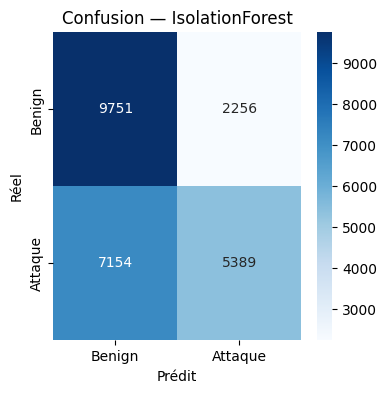

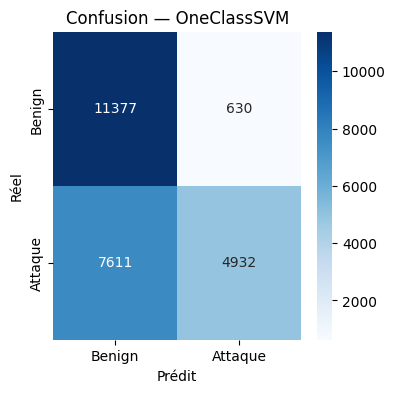

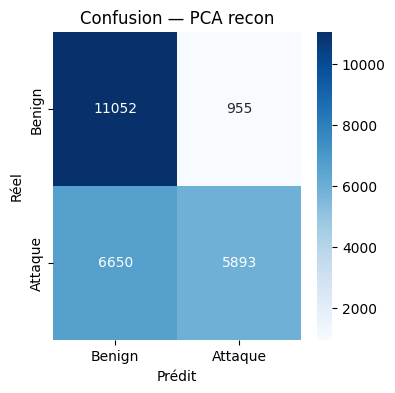

,scenario,title,precision,recall,auprc,balanced_acc,mcc
0,Binaire,Non supervisé - IsolationForest,0.704905,0.429642,0.712733,0.620876,0.260970
1,Binaire,Non supervisé - OneClassSVM,0.886731,0.393207,0.772718,0.670369,0.406896
2,Binaire,Non supervisé - PCA recon,0.860543,0.469824,0.732306,0.695143,0.435020


In [5]:
results = []
artifacts = {}


contam = float(np.clip(float(np.mean(binary_scenario["y_train"])), 0.01, 0.30))
iso = IsolationForest(n_estimators=300, contamination=contam, random_state=RANDOM_STATE, n_jobs=-1)
iso.fit(binary_scenario["X_train"][binary_scenario["y_train"] == 0])
iso_pred = (iso.predict(binary_scenario["X_test"]) == -1).astype(int)
iso_score = -iso.score_samples(binary_scenario["X_test"])


oc = OneClassSVM(kernel="rbf", nu=0.05, gamma="scale")
oc.fit(binary_scenario["X_train"][binary_scenario["y_train"] == 0])
oc_pred = (oc.predict(binary_scenario["X_test"]) == -1).astype(int)
oc_score = -oc.decision_function(binary_scenario["X_test"])


pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
pca.fit(binary_scenario["X_train"][binary_scenario["y_train"] == 0])
recon_error = np.mean((binary_scenario["X_test"] - pca.inverse_transform(pca.transform(binary_scenario["X_test"]))) ** 2, axis=1)
train_recon_error = np.mean((binary_scenario["X_train"][binary_scenario["y_train"] == 0] - pca.inverse_transform(pca.transform(binary_scenario["X_train"][binary_scenario["y_train"] == 0]))) ** 2, axis=1)
pca_pred = (recon_error > np.quantile(train_recon_error, 0.95)).astype(int)





results.append(eval(binary_scenario["y_test"], iso_pred, iso_score, title=f"Non supervisé - IsolationForest"))
results.append(eval(binary_scenario["y_test"], oc_pred, oc_score, title=f"Non supervisé - OneClassSVM"))
results.append(eval(binary_scenario["y_test"], pca_pred, recon_error, title=f"Non supervisé - PCA recon"))
for r in results:
	r["scenario"] = binary_scenario["name"]

artifacts["iso_pred"] = iso_pred
artifacts["oc_pred"] = oc_pred
artifacts["pca_pred"] = pca_pred

plot_confusion_matrix(binary_scenario["y_test"], artifacts["iso_pred"],   "Confusion — IsolationForest", class_names=["Benign", "Attaque"])
plot_confusion_matrix(binary_scenario["y_test"], artifacts["oc_pred"],    "Confusion — OneClassSVM", class_names=["Benign", "Attaque"])
plot_confusion_matrix(binary_scenario["y_test"], artifacts["pca_pred"],   "Confusion — PCA recon", class_names=["Benign", "Attaque"])

unsup_df = pd.DataFrame(results)
unsup_df = unsup_df[["scenario", "title", "precision", "recall", "auprc", "balanced_acc", "mcc"]]
unsup_df


## 4B. Partie Binaire — Supervisé

Objectif : classifier **Benign vs Attack** avec des modèles supervisés entraînés sur `df_binaire`.

Point critique : split **par fichier** (colonne `group`) pour éviter la fuite.


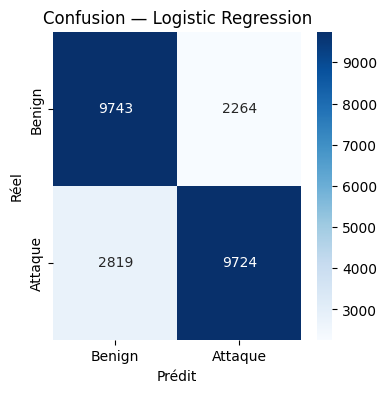

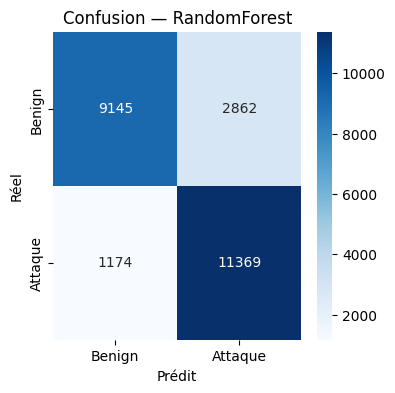

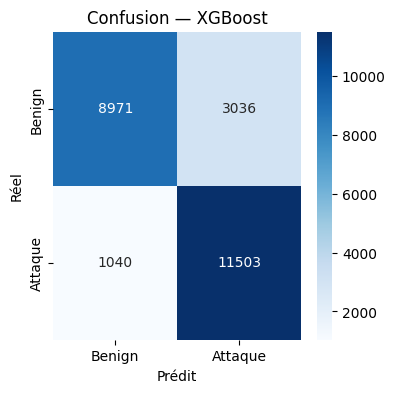

,scenario,title,precision,recall,auprc,balanced_acc,mcc
0,Binaire,Régression logistique,0.811144,0.775253,0.901445,0.793348,0.586717
1,Binaire,RandomForest,0.798890,0.906402,0.891412,0.834021,0.676526
2,Binaire,XGBoost,0.791182,0.917085,0.949507,0.832116,0.675666


In [6]:
results = []
artifacts = {}

lr = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE)
lr.fit(binary_scenario["X_train"], binary_scenario["y_train"])
lr_pred = lr.predict(binary_scenario["X_test"])
lr_score = lr.predict_proba(binary_scenario["X_test"])[:, 1]


rf = RandomForestClassifier(n_estimators=400,random_state=RANDOM_STATE,n_jobs=-1,class_weight="balanced_subsample")
rf.fit(binary_scenario["X_train"], binary_scenario["y_train"])
rf_pred = rf.predict(binary_scenario["X_test"])
rf_score = rf.predict_proba(binary_scenario["X_test"])[:, 1]


xgb_clf = xgb.XGBClassifier(
	n_estimators=600,
	max_depth=8,
	learning_rate=0.05,
	subsample=0.8,
	colsample_bytree=0.8,
	reg_lambda=1.0,
	min_child_weight=1,
	tree_method="hist",
	eval_metric="logloss",
	random_state=RANDOM_STATE,
	n_jobs=-1,
)
xgb_clf.fit(binary_scenario["X_train"], binary_scenario["y_train"])
xgb_score = xgb_clf.predict_proba(binary_scenario["X_test"])[:, 1]
xgb_pred = (xgb_score >= 0.5).astype(int)



results.append(eval(binary_scenario["y_test"], lr_pred, lr_score, title=f"Régression logistique"))
results.append(eval(binary_scenario["y_test"], rf_pred, rf_score, title=f"RandomForest"))
results.append(eval(binary_scenario["y_test"], xgb_pred, xgb_score, title=f"XGBoost"))

artifacts["lr_pred"] = lr_pred
artifacts["rf_pred"] = rf_pred
artifacts["xgb_pred"] = xgb_pred
artifacts["xgb_model"] = xgb_clf

for r in results:
	r["scenario"] = binary_scenario["name"]

plot_confusion_matrix(binary_scenario["y_test"], artifacts["lr_pred"], "Confusion — Logistic Regression", class_names=["Benign", "Attaque"])
plot_confusion_matrix(binary_scenario["y_test"], artifacts["rf_pred"], "Confusion — RandomForest", class_names=["Benign", "Attaque"])
plot_confusion_matrix(binary_scenario["y_test"], artifacts["xgb_pred"], "Confusion — XGBoost", class_names=["Benign", "Attaque"])

sup_df = pd.DataFrame(results)
sup_df = sup_df[["scenario", "title", "precision", "recall", "auprc", "balanced_acc", "mcc"]]
sup_df


In [7]:
binary_table = pd.concat([unsup_df, sup_df], ignore_index=True)

binary_table = binary_table[[
    "title",
    "precision",
    "recall",
    "auprc",
    "balanced_acc",
    "mcc",
]]

binary_table

,title,precision,recall,auprc,balanced_acc,mcc
0,Non supervisé - IsolationForest,0.704905,0.429642,0.712733,0.620876,0.260970
1,Non supervisé - OneClassSVM,0.886731,0.393207,0.772718,0.670369,0.406896
2,Non supervisé - PCA recon,0.860543,0.469824,0.732306,0.695143,0.435020
3,Régression logistique,0.811144,0.775253,0.901445,0.793348,0.586717
4,RandomForest,0.798890,0.906402,0.891412,0.834021,0.676526
5,XGBoost,0.791182,0.917085,0.949507,0.832116,0.675666


## 5. Partie Familles

Objectif : passer du binaire à la classification multi-classes par **familles d’attaques** (`attack_family`).

Remarque : selon la distribution des fichiers, certaines familles peuvent être absentes de `y_test` ; les matrices de confusion n’affichent que les classes présentes dans `y_test`.


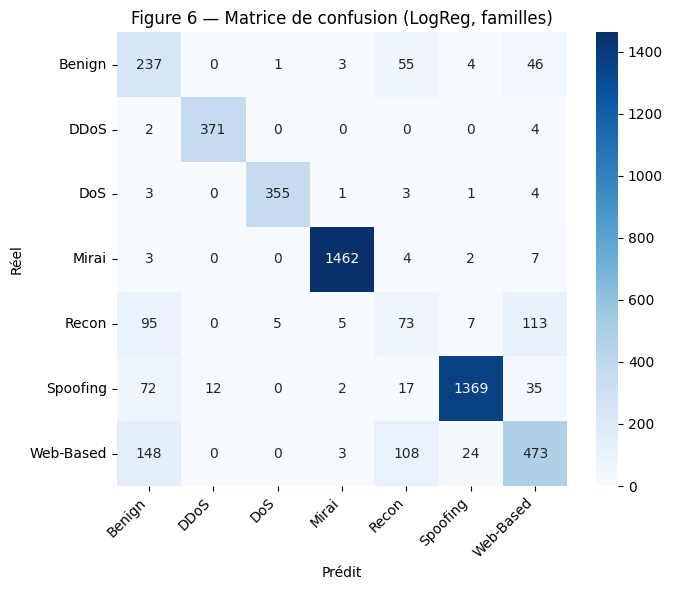

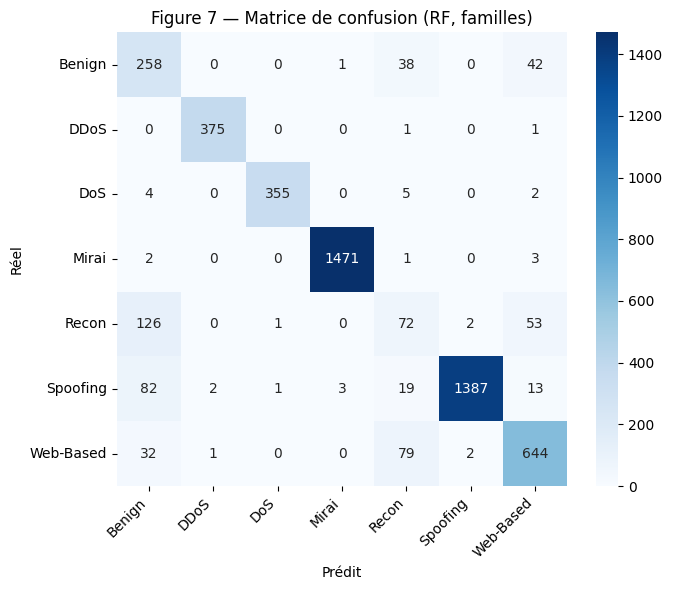

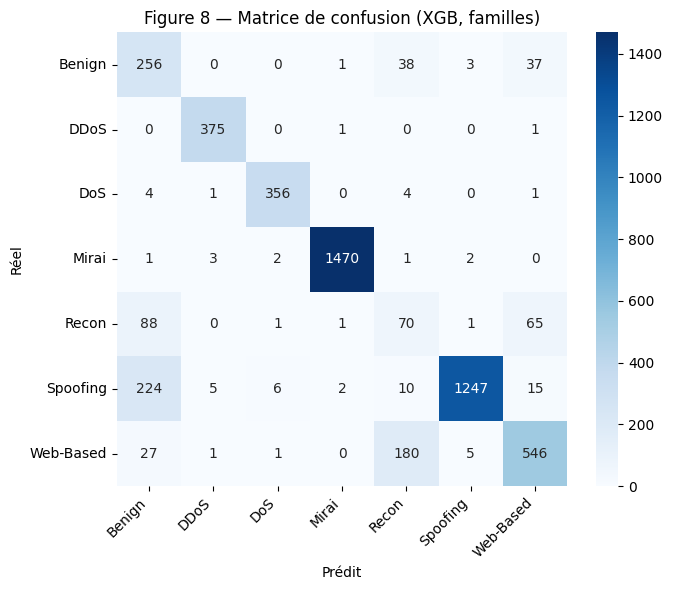

,scenario,title,precision,recall,auprc,balanced_acc,mcc
0,Familles,LogisticRegression,0.759012,0.761418,0.780206,0.772084,0.789676
1,Familles,RandomForest,0.811038,0.805606,0.841111,0.825011,0.842785
2,Familles,XGBoost,0.773330,0.772791,0.813986,0.797142,0.788537


In [8]:
fam_results = []
artifacts = {}



lr = LogisticRegression(max_iter=3000, class_weight="balanced", random_state=RANDOM_STATE)
lr.fit(family_scenario["X_train"], family_scenario["y_train"])
lr_pred = lr.predict(family_scenario["X_test"])
lr_proba = lr.predict_proba(family_scenario["X_test"])


rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE, class_weight="balanced_subsample")
rf.fit(family_scenario["X_train"], family_scenario["y_train"])
rf_pred = rf.predict(family_scenario["X_test"])
rf_proba = rf.predict_proba(family_scenario["X_test"])


xgb_clf = xgb.XGBClassifier(
    n_estimators=800,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    objective="multi:softprob",
    num_class=len(family_scenario["classes"]),
    eval_metric="mlogloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
xgb_clf.fit(family_scenario["X_train"], family_scenario["y_train"])
xgb_proba = xgb_clf.predict_proba(family_scenario["X_test"])
xgb_pred = np.argmax(xgb_proba, axis=1)




artifacts["lr_pred"] = lr_pred
artifacts["rf_pred"] = rf_pred
artifacts["xgb_pred"] = xgb_pred

fam_results.append(eval(family_scenario["y_test"], lr_pred, y_score=lr_proba, title="LogisticRegression", classes=lr.classes_))
fam_results.append(eval(family_scenario["y_test"], rf_pred, y_score=rf_proba, title="RandomForest", classes=rf.classes_))
fam_results.append(eval(family_scenario["y_test"], xgb_pred, y_score=xgb_proba, title="XGBoost", classes=np.arange(len(family_scenario["classes"]))))
for r in fam_results:
    r["scenario"] = family_scenario["name"]

fam_labels = np.unique(family_scenario["y_test"])
fam_names = [family_scenario["classes"][i] for i in fam_labels]
plot_confusion_matrix(family_scenario["y_test"], artifacts["lr_pred"], labels=fam_labels, class_names=fam_names, title="Figure 6 — Matrice de confusion (LogReg, familles)")
plot_confusion_matrix(family_scenario["y_test"], artifacts["rf_pred"], labels=fam_labels, class_names=fam_names, title="Figure 7 — Matrice de confusion (RF, familles)")
plot_confusion_matrix(family_scenario["y_test"], artifacts["xgb_pred"], labels=fam_labels, class_names=fam_names, title="Figure 8 — Matrice de confusion (XGB, familles)")

fam_df = pd.DataFrame(fam_results)
fam_df = fam_df[["scenario", "title", "precision", "recall", "auprc", "balanced_acc", "mcc"]]
fam_df


## 6. Partie Sous-familles

Objectif : affiner au niveau des **sous-types** (`attack_subtype`).

Défi : classes très déséquilibrées et parfois trop peu de fichiers. On conserve un split **par fichier** et on n’affiche en matrice de confusion que les classes présentes dans `y_test`.


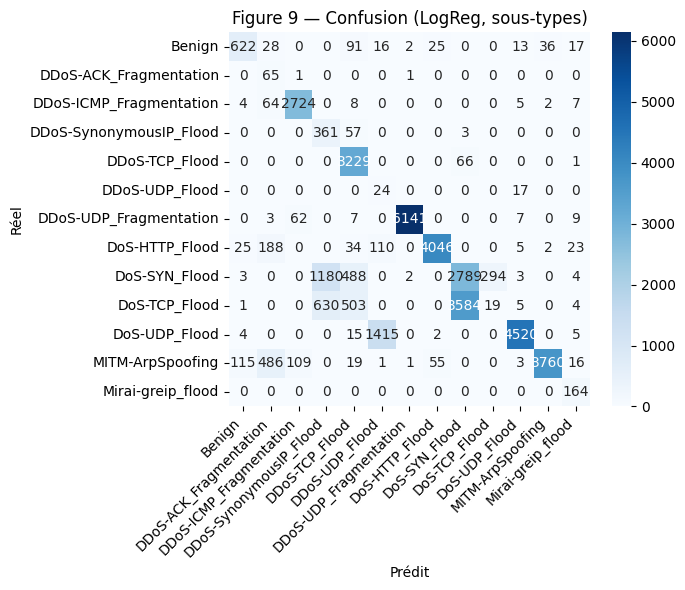

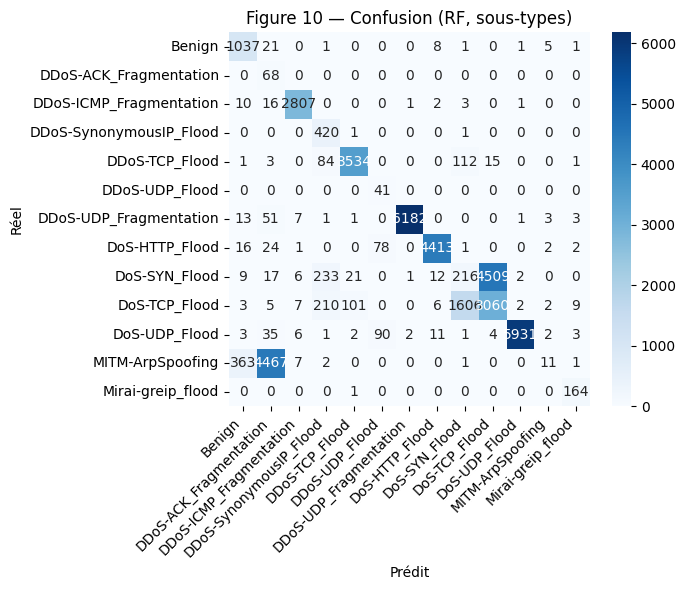

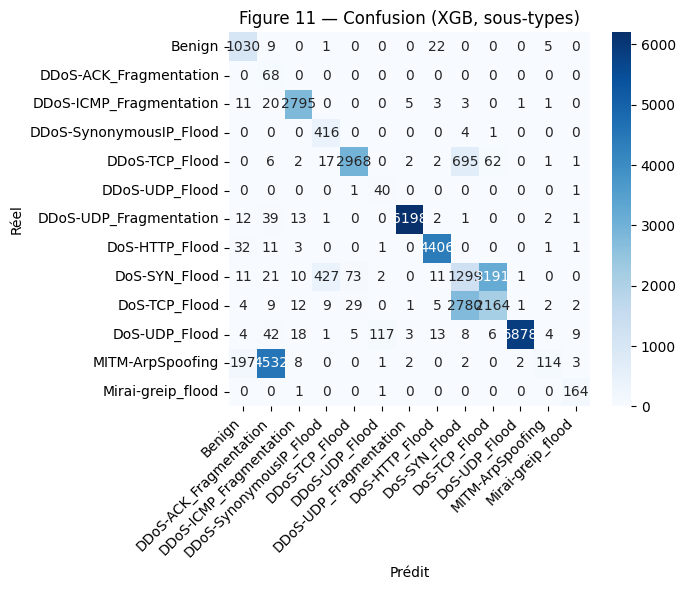

,scenario,title,precision,recall,auprc,balanced_acc,mcc
0,Sous-types,LogisticRegression,0.602679,0.730350,0.732860,0.781731,0.665218
1,Sous-types,RandomForest,0.627159,0.782538,0.859744,0.805704,0.654114
2,Sous-types,XGBoost,0.684891,0.771472,0.860444,0.793895,0.640801


In [9]:
st_results = []
artifacts = {}



lr_st = LogisticRegression(max_iter=4000,class_weight="balanced",solver="saga",random_state=RANDOM_STATE)
lr_st.fit(st_scenario["X_train"], st_scenario["y_train"])
lr_pred = lr_st.predict(st_scenario["X_test"])
lr_proba = lr_st.predict_proba(st_scenario["X_test"])


rf_st = RandomForestClassifier(n_estimators=150,n_jobs=-1,random_state=RANDOM_STATE,class_weight="balanced_subsample")
rf_st.fit(st_scenario["X_train"], st_scenario["y_train"])
rf_pred = rf_st.predict(st_scenario["X_test"])
rf_proba = rf_st.predict_proba(st_scenario["X_test"])


xgb_st = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    objective="multi:softprob",
    num_class=len(st_scenario["classes"]),
    eval_metric="mlogloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
xgb_st.fit(st_scenario["X_train"], st_scenario["y_train"])
xgb_proba = xgb_st.predict_proba(st_scenario["X_test"])
xgb_pred = np.argmax(xgb_proba, axis=1)



artifacts["lr_pred"] = lr_pred
artifacts["rf_pred"] = rf_pred
artifacts["xgb_pred"] = xgb_pred

st_results.append(eval(st_scenario["y_test"], lr_pred, y_score=lr_proba, title="LogisticRegression", classes=lr_st.classes_))
st_results.append(eval(st_scenario["y_test"], rf_pred, y_score=rf_proba, title="RandomForest", classes=rf_st.classes_))
st_results.append(eval(st_scenario["y_test"], xgb_pred, y_score=xgb_proba, title="XGBoost", classes=np.arange(len(st_scenario["classes"]))))
for r in st_results:
    r["scenario"] = st_scenario["name"]

st_labels = np.unique(st_scenario["y_test"])
st_names = [st_scenario["classes"][i] for i in st_labels]
plot_confusion_matrix(st_scenario["y_test"], artifacts["lr_pred"], labels=st_labels, class_names=st_names, title="Figure 9 — Confusion (LogReg, sous-types)")
plot_confusion_matrix(st_scenario["y_test"], artifacts["rf_pred"], labels=st_labels, class_names=st_names, title="Figure 10 — Confusion (RF, sous-types)")
plot_confusion_matrix(st_scenario["y_test"], artifacts["xgb_pred"], labels=st_labels, class_names=st_names, title="Figure 11 — Confusion (XGB, sous-types)")

st_df = pd.DataFrame(st_results)
st_df = st_df[["scenario", "title", "precision", "recall", "auprc", "balanced_acc", "mcc"]]
st_df


In [10]:
fam_table = pd.DataFrame(fam_results)[[
    "title",
    "precision",
    "recall",
    "auprc",
    "balanced_acc",
    "mcc",
]]

st_table = pd.DataFrame(st_results)[[
    "title",
    "precision",
    "recall",
    "auprc",
    "balanced_acc",
    "mcc",
]]

def pick_best(df, metric, higher_is_better=True):
    d = df.dropna(subset=[metric]).copy()
    idx = d[metric].idxmax() if higher_is_better else d[metric].idxmin()
    return d.loc[idx]

best_bin = pick_best(binary_table, metric="auprc")
best_fam = pick_best(fam_table, metric="balanced_acc")
best_st = pick_best(st_table, metric="balanced_acc") if "st_table" in globals() else None

rows = []
rows.append({
	"task": "Binaire",
	"best_model": best_bin["title"],
	"metric": "AUPRC",
	"value": float(best_bin["auprc"]),
})
rows.append({
	"task": "Familles",
	"best_model": best_fam["title"],
	"metric": "Balanced Acc",
	"value": float(best_fam["balanced_acc"]),
})
rows.append({
	"task": "Sous-types",
	"best_model": best_st["title"],
	"metric": "Balanced Acc",
	"value": float(best_st["balanced_acc"]),
})

pd.DataFrame(rows)


,task,best_model,metric,value
0,Binaire,XGBoost,AUPRC,0.949507
1,Familles,RandomForest,Balanced Acc,0.825011
2,Sous-types,RandomForest,Balanced Acc,0.805704


## 7. Conclusions

Points clés à rapporter :
- Le dataset est déséquilibré (Benign majoritaire), ce qui rend l’AUPRC particulièrement pertinente.
- Le split **par fichier** évite la fuite de données et rend l’évaluation plus crédible.
- Le projet couvre 3 niveaux complémentaires : **détecter** (binaire), **tracker haut niveau** (familles), **tracker fin** (sous-types).


## 7 bis. Conclusions cyber par niveau

**Partie 1 — Binaire (détecter)**
- Identifier le meilleur modèle (souvent XGBoost/RF) selon AUPRC et compromis FP/FN.
- Justifier l’usage des courbes PR (dataset déséquilibré) plutôt que l’accuracy.
- Interpréter les erreurs : faux positifs (alert fatigue) vs faux négatifs (attaques manquées).

**Partie 2A — Familles (tracker haut niveau)**
- Mettre en avant les familles les plus confondues via `top_confusions` et proposer une explication réseau (patterns proches).
- Comparer macro vs weighted : macro reflète l’équité entre familles rares/majoritaires.

**Partie 2B — Sous-types (tracker fin)**
- Montrer l’effet du déséquilibre et l’intérêt du filtrage + regroupement `Other` (évaluation stable, moins de classes fantômes).
- Discuter la limite : plus de granularité = plus de variance / besoin de données par sous-type.
